In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import math

import sys
sys.path.append("../..")
from src.load_datasets import load_dataset, load_rankings, load_train_data
import src.evaluate_regression
import time

# From example
import src.encoder_utils as eu
import src.evaluate_regression as er
import src.load_datasets as ld
import src.pairwise_utils as pu

from category_encoders import OneHotEncoder
from pathlib import Path
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# Classifiers
from sklearn.multioutput import MultiOutputClassifier

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier

import xgboost
import catboost 
import lightgbm

# Example

- With CV
- Without preprocessing

In [3]:
# Define variables for ranking
factors = ["dataset", "model", "tuning", "scoring"]
new_index = "encoder"
target = "rank"

In [4]:
df_train = ld.load_dataset("../../data/raw/dataset_rank_train.csv")

if "cv_score" in df_train.columns:
    df_train = df_train.drop("cv_score", axis=1)

Loading data from '../../data/raw/dataset_rank_train.csv' ...


In [5]:
df_train = pd.pivot(df_train, index=factors, columns="encoder", values="rank").reset_index()
X_train = df_train[factors]
y_train = df_train.drop(factors, axis=1)
y_train = y_train.fillna(np.max(y_train))

### Preprocessing

- Do not preprocess (embed) the encoder features (because it is not present in this task)

In [6]:
import src.encoding
from src.feature_engineering import normalize_train_data, normalize_test_data
from src.meta_information import add_dataset_meta_information
from src.data_cleaning import drop_pearson_correlated_features

In [7]:
base_df = df_train[factors].copy()
print(base_df.columns)

Index(['dataset', 'model', 'tuning', 'scoring'], dtype='object', name='encoder')


In [8]:
# OHE encoding 
X_train, ohe = src.encoding.ohe_encode_train_data(X_train=X_train,
                                                  cols_to_encode=["model", "tuning", "scoring"],
                                                  verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the train data ...


In [9]:
base_df_mod = src.encoding.ohe_encode_test_data(X_test=base_df,
                                                cols_to_encode=["model", "tuning", "scoring"],
                                                ohe=ohe, 
                                                verbosity=2)

One Hot Encoding the features ['model', 'tuning', 'scoring'] of the test data ...


In [10]:
X_train = add_dataset_meta_information(df=X_train,
                                       path_to_meta_df="../../data/preprocessed/dataset_agg.csv",
                                       nan_threshold=0.5,
                                       replacing_strategy="median")

In [11]:
X_train, _ = drop_pearson_correlated_features(train_data=X_train, 
                                              test_data=None, 
                                              threshold=0.7, 
                                              verbosity=2)

Drop pearson correlated features with threshold 0.7...
Filter correlated features


In [12]:
X_train, scaler = normalize_train_data(X_train=X_train, 
                                       method="minmax",
                                       verbosity=2)

Normalizing train data using method 'minmax' ...


## Modelling

In [13]:
import tensorflow as tf
import tensorflow_ranking as tfr
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
np.random.seed(42)

2023-07-23 18:04:11.714918: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 18:04:11.775233: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-23 18:04:11.776585: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-23 18:04:12.879404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
cv_indices = src.evaluate_regression.custom_cross_validated_indices(pd.concat([X_train, y_train], axis=1), 
                                                                    list(X_train.columns), 
                                                                    list(y_train.columns),  #target 
                                                                    n_splits=5, 
                                                                    shuffle=True, 
                                                                    random_state=1444)

In [15]:
train_val_test_indices = src.evaluate_regression.train_val_test_split(pd.concat([X_train, y_train], axis=1), 
                                                                      list(X_train.columns), 
                                                                      list(y_train.columns),  #target 
                                                                      n_splits=5, 
                                                                      shuffle=True, 
                                                                      random_state=1444)

In [16]:
len(train_val_test_indices)
len(train_val_test_indices[0])

# Check if indices do not overlap
for fold in train_val_test_indices:
    if len(set(fold[0]).intersection(set(fold[1]))) > 0:
        print("Overlap between train and val")
    if len(set(fold[0]).intersection(set(fold[2]))) > 0:
        print("Overlap between train and test")
    if len(set(fold[1]).intersection(set(fold[2]))) > 0:
        print("Overlap between val and test")

In [38]:
X_train.head()

,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,NumberOfSymbolicFeatures,MinMutualInformation,PercentageOfInstancesWithMissingValues,MinNominalAttDistinctValues,NumberOfNumericFeatures,rows_with_null_values_count,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,min_number_of_categories_per_cat_feature
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.270073,4.793819e-08,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.015152


### Define models and parameters

In [15]:
# Parameters
epochs = 500
batch_size = 16
#patience = 20
learning_rate = 0.001

# In- and output shapes
input_shape = X_train.shape[1]
output_shape = y_train.shape[1]


# Callbacks for early stopping and reduce LR
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # val_loss
    patience=40,  # Number of epochs without improvement
    restore_best_weights=True
)

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,         # Reduce the learning rate by half when the validation loss plateaus
    patience=25,        # Number of epochs with no improvement after which the learning rate will be reduced
    min_lr=1e-7,        # Lower bound on the learning rate
    verbose=1
)

In [18]:
# CNN
# Avg spearman .16 - .18 
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(40, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(40, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(40, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=32, activation='relu')  # 32 output classes for the target
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, 
              loss=tfr.keras.losses.ListMLELoss())

tmp_models = [model]

In [32]:
# Linear model
def generate_linear_model(input_shape, 
                          output_shape, 
                          units, 
                          layers, 
                          learning_rate, 
                          dropout_rate, 
                          regularization):
    
    # Units and layers must have same length
    assert len(units) == len(layers)
    
    # Define model according to the given parameters
    model_definition = []
    
    # Input layer
    model_definition.append(tf.keras.layers.Dense(units=input_shape, activation="relu"))
    
    # Inner layers
    for i, (u, l) in enumerate(zip(units, layers)):
        for j in range(l):
            model_definition.append(tf.keras.layers.Dense(units=u, activation="relu"))
            if regularization == "bn":
                model_definition.append(tf.keras.layers.BatchNormalization())
            elif regularization == "dropout":
                model_definition.append(tf.keras.layers.Dropout(rate=dropout_rate, seed=42))  # model 00: avg spearman: ~0.84 +- 0.09
    
    
    # Output layer
    model_definition.append(tf.keras.layers.Dense(units=output_shape))  # softmax is bad 
    model = tf.keras.Sequential(model_definition)
    
    # Compile model
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=tfr.keras.losses.ListMLELoss())
    
    return model

In [20]:
tmp_models = []

# 00
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[1, 1], 
                          learning_rate=learning_rate)
)
# 01
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[1, 2], 
                          learning_rate=learning_rate)
)
# 02
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[1, 3], 
                          learning_rate=learning_rate)
)
# 03
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[2, 1], 
                          learning_rate=learning_rate)
)
# 04
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[2, 2], 
                          learning_rate=learning_rate)
)
# 05
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[2, 3], 
                          learning_rate=learning_rate)
)
# 06
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[3, 1], 
                          learning_rate=learning_rate)
)
# 07
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[3, 2], 
                          learning_rate=learning_rate)
)
# 08
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[3, 3], 
                          learning_rate=learning_rate)
)
# 09
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 512, 256], 
                          layers=[1, 2, 3], 
                          learning_rate=learning_rate)
)
# 10
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 512, 256], 
                          layers=[2, 2, 2], 
                          learning_rate=learning_rate)
)
# 11
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 512, 256, 128], 
                          layers=[1, 2, 3, 2], 
                          learning_rate=learning_rate)
)

### Tested [0, 11]
### 
# 	avg_spearman
#	mean 	std
#model 		
#sequential_0 	0.748493 	0.092364
#sequential_1 	0.716876 	0.079213
#sequential_10 	0.484873 	0.058413
#sequential_11 	0.427467 	0.054074
#sequential_2 	0.602948 	0.087575
#sequential_3 	0.675060 	0.113726
#sequential_4 	0.661729 	0.084149
#sequential_5 	0.630556 	0.091651
#sequential_6 	0.738342 	0.100320
#sequential_7 	0.467723 	0.061170
#sequential_8 	0.455138 	0.057073
#sequential_9 	0.409119 	0.073842

# Take 0 and 6 and modify them
# Also try deeper networks 

# 12 == 01
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[1, 1], 
                          learning_rate=learning_rate)
)
# 13 == 06
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[3, 1], 
                          learning_rate=learning_rate)
)
# 14
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 512], 
                          layers=[1, 1], 
                          learning_rate=learning_rate)
)
# 15
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 256], 
                          layers=[1, 1], 
                          learning_rate=learning_rate)
)
# 16
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 128], 
                          layers=[3, 1], 
                          learning_rate=learning_rate)
)
# 17
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024, 256], 
                          layers=[3, 1], 
                          learning_rate=learning_rate)
)
# 18
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[5, 1], 
                          learning_rate=learning_rate)
)
# 19
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[2048, 1024, 512, 256], 
                          layers=[4, 4, 4, 4], 
                          learning_rate=learning_rate)
)
tmp_models = tmp_models[12:]

In [17]:
tmp_models = []
# 12
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[512, 256], 
                          layers=[1, 1], 
                          learning_rate=1e-03, 
                          dropout_rate=0.3)
)
# 13 == 06
#tmp_models.append(
#    generate_linear_model(input_shape=input_shape, 
#                          output_shape=output_shape, 
#                          units=[512, 256], 
#                          layers=[3, 1], 
#                          learning_rate=0.001)
#)
# 15
#tmp_models.append(
#    generate_linear_model(input_shape=input_shape, 
#                          output_shape=output_shape, 
#                          units=[1024, 256], 
#                          layers=[1, 1], 
#                          learning_rate=0.001)
#)
tmp_models.append(
    generate_linear_model(input_shape=input_shape, 
                          output_shape=output_shape, 
                          units=[1024], 
                          layers=[1], 
                          learning_rate=0.0001,
                          dropout_rate=0.3)
)
#tmp_models.append(
#    generate_linear_model(input_shape=input_shape, 
#                          output_shape=output_shape, 
#                          units=[128, 256, 512, 256, 128], 
#                          layers=[1, 1, 1, 1, 1], 
#                          learning_rate=0.01)
#)

In [27]:
y_train.head()

encoder,BE,BUCV10RGLMME,BUCV10TE,BUCV2RGLMME,BUCV2TE,BUCV5RGLMME,BUCV5TE,CBE,CE,CV10RGLMME,...,MHE,OE,OHE,PBTE0001,PBTE001,PBTE01,RGLMME,SE,TE,WOEE
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
3,12.0,14.0,0.0,18.0,6.0,17.0,4.0,24.0,8.0,16.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0
4,12.0,13.0,0.0,18.0,6.0,16.0,4.0,25.0,8.0,15.0,...,2.0,9.0,5.0,7.0,11.0,23.0,19.0,1.0,3.0,3.0


### Training and evaluation

In [36]:
batch_size = 16

models = []
folds = []
scores = []
history = []
train_time = []
pred_time = []

for j, fold in enumerate(cv_indices):
    models.append(f"sequential")
    folds.append(j)

    # Get train and test data for current split
    #X_tr = X_train.iloc[fold[0]].copy()  #.reshape(-1, 40, 1)
    #X_va = X_train.iloc[fold[1]].copy()  #.reshape(-1, 40, 1)
    #X_te = X_train.iloc[fold[2]].copy()  #.reshape(-1, 40, 1)
    #y_tr = y_train.iloc[fold[0]].copy()  #.reshape(-1, 40, 1)
    #y_va = y_train.iloc[fold[1]].copy()  #.reshape(-1, 40, 1)
    #y_te = y_train.iloc[fold[2]].copy()  #.reshape(-1, 40, 1)
    X_tr = X_train.iloc[fold[0]].copy()  #.reshape(-1, 40, 1)
    X_te = X_train.iloc[fold[1]].copy()  #.reshape(-1, 40, 1)
    y_tr = y_train.iloc[fold[0]].copy()  #.reshape(-1, 40, 1)
    y_te = y_train.iloc[fold[1]].copy()  #.reshape(-1, 40, 1)

    # Get data for evaluation
    base_df_test_slice = base_df.iloc[fold[1]]

    # For CNN
    #X_tr = np.array(X_tr).reshape(-1, 40, 1)
    #y_tr = np.array(y_tr).reshape(-1, 32)
    #X_te = np.array(X_te).reshape(-1, 40, 1)
    #y_te = np.array(y_te).reshape(-1, 32)

    model = generate_linear_model(input_shape=input_shape, 
                      output_shape=output_shape, 
                      units=[64, 256, 64], 
                      layers=[1, 1, 1], 
                      learning_rate=0.001, 
                      dropout_rate=0.1, 
                      regularization="dropout")

    # Prepare dataset
    # train_dataset = tf.data.Dataset.from_tensor_slices((X_tr_np, y_tr_np)).batch(batch_size)
    train_dataset = tf.data.Dataset.from_tensor_slices((X_tr, y_tr)).batch(batch_size)

    # Train 
    start_train_time = time.time()
    history.append(
        model.fit(train_dataset, 
                  epochs=epochs, 
                  callbacks=[early_stopping_callback, reduce_lr_callback], 
                  #validation_data=(X_te, y_te),
                  verbose=0)
    )
    end_train_time = time.time()
    train_time.append(end_train_time - start_train_time)
    
    # Predict
    start_pred_time = time.time()
    y_pred = pd.DataFrame(model.predict(X_te), columns=y_tr.columns, index=X_te.index)
    end_pred_time = time.time()
    pred_time.append(end_pred_time - start_pred_time)

    # Validate with 
    test_dataset = tf.data.Dataset.from_tensor_slices((X_te, y_te)).batch(batch_size)
    results = model.evaluate(test_dataset)

    # Score with avg spearman
    df_pred = pd.merge(pd.concat([base_df_test_slice, y_te], axis=1).melt(id_vars=factors, value_name="rank").dropna(axis=0),
                       pd.concat([base_df_test_slice, y_pred], axis=1).melt(id_vars=factors, value_name="rank_pred"),
                       on=factors+["encoder"], how="left")
    rankings_test = er.get_rankings(df_pred.drop_duplicates(), factors=factors, new_index=new_index, target="rank")
    rankings_pred = er.get_rankings(df_pred.drop_duplicates(), factors=factors, new_index=new_index, target="rank_pred")
    scores.append(er.average_spearman(rankings_test, rankings_pred))
    print(f"Avg Spearman fold {j}: {round(np.mean(scores[-1:]), 4)}")

# Print scores
print(f"Avg Spearman: {round(np.mean(scores[-5:]), 4)} +/- {round(np.std(scores[-5:]), 4)}")
print("")


Epoch 477: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 520: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 646: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
15/15 [==============================] - 0s 1ms/step - loss: 71.3256
Avg Spearman fold 0: 0.6484

Epoch 403: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
15/15 [==============================] - 0s 2ms/step - loss: nan


ValueError: nan is not in list

In [28]:
y_pred.head()

encoder,BE,BUCV10RGLMME,BUCV10TE,BUCV2RGLMME,BUCV2TE,BUCV5RGLMME,BUCV5TE,CBE,CE,CV10RGLMME,...,MHE,OE,OHE,PBTE0001,PBTE001,PBTE01,RGLMME,SE,TE,WOEE
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
scores

[0.6739486302860737,
 0.8852141780388125,
 0.8616582176831797,
 0.8931069292169341,
 0.8866320950524343,
 0.4976450407531184,
 0.62010538984552,
 0.6812000935488782,
 0.6812626567768691,
 0.7015480068473998]

In [82]:
scores[-5:]

[0.4976450407531184,
 0.62010538984552,
 0.6812000935488782,
 0.6812626567768691,
 0.7015480068473998]

# Plots

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt


# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set()
sns.set_theme(style="whitegrid")
#sns.set_palette(palette="Set2")
sns.set_palette(palette="Paired")
# set seed
np.random.seed(7)

In [28]:
df_plot = pd.DataFrame(data={
    "model": models,                # contains models
    "fold": folds,
    "history": history,             # contains list with entry per fold
    "fitting_time": train_time,     # contains list with entry per fold
    "prediction_time": pred_time,   # contains list with entry per fold 
    "avg_spearman": scores,         # contains list with entry per fold
})

df_plot.head(10)

,model,fold,history,fitting_time,prediction_time,avg_spearman
0,sequential_0,0,<keras.src.callbacks.History object at 0x7f11b...,3.554224,0.074419,0.652734
1,sequential_0,1,<keras.src.callbacks.History object at 0x7f11b...,3.249361,0.077031,0.736964
2,sequential_0,2,<keras.src.callbacks.History object at 0x7f119...,3.270780,0.075669,0.707944
3,sequential_0,3,<keras.src.callbacks.History object at 0x7f119...,3.367309,0.076822,0.736797
4,sequential_0,4,<keras.src.callbacks.History object at 0x7f119...,3.268662,0.076556,0.736307
5,sequential_1,0,<keras.src.callbacks.History object at 0x7f119...,5.138653,0.083223,0.447592
6,sequential_1,1,<keras.src.callbacks.History object at 0x7f119...,6.057100,0.082161,0.502741
7,sequential_1,2,<keras.src.callbacks.History object at 0x7f119...,5.136552,0.081815,0.474588
8,sequential_1,3,<keras.src.callbacks.History object at 0x7f119...,5.688889,0.080985,0.497861
9,sequential_1,4,<keras.src.callbacks.History object at 0x7f119...,11.439835,0.085043,0.488083


In [28]:
# Model 0 - 11
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman          
                      mean       std
model                               
sequential_0      0.748493  0.092364
sequential_1      0.716876  0.079213
sequential_10     0.484873  0.058413
sequential_11     0.427467  0.054074
sequential_2      0.602948  0.087575
sequential_3      0.675060  0.113726
sequential_4      0.661729  0.084149
sequential_5      0.630556  0.091651
sequential_6      0.738342  0.100320
sequential_7      0.467723  0.061170
sequential_8      0.455138  0.057073
sequential_9      0.409119  0.073842

In [22]:
# Model 12 - 19
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman          
                     mean       std
model                              
sequential_0     0.748493  0.092364
sequential_1     0.613442  0.079309
sequential_2     0.723790  0.109366
sequential_3     0.749048  0.094617
sequential_4     0.738523  0.111785
sequential_5     0.674114  0.095163
sequential_6     0.434878  0.113155
sequential_7     0.098561  0.009498

In [27]:
# Model 0, 6, 15
# LR 0.01
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman          
                     mean       std
model                              
sequential_0     0.241275  0.018245
sequential_1     0.015324  0.003366
sequential_2     0.045721  0.007396

In [31]:
# Model 0, 6, 15
# LR 0.0001
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman          
                     mean       std
model                              
sequential_0     0.621556  0.072149
sequential_1     0.607717  0.072483
sequential_2     0.676526  0.081897

In [23]:
# Model 0, 6, 15
# LR 0.001
# Batch size: 8
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman    
                     mean std
model                        
sequential_0          NaN NaN
sequential_1          NaN NaN
sequential_2          NaN NaN

In [29]:
# Model 0, 6, 15
# LR 0.001
# Batch size: 32
df_plot[["model", "avg_spearman"]].groupby("model").agg({'avg_spearman':['mean','std']})

avg_spearman          
                     mean       std
model                              
sequential_0     0.714149  0.036520
sequential_1     0.482173  0.022121
sequential_2     0.632238  0.021784

### Average spearman

Text(0.5, 0, 'Average Spearman')

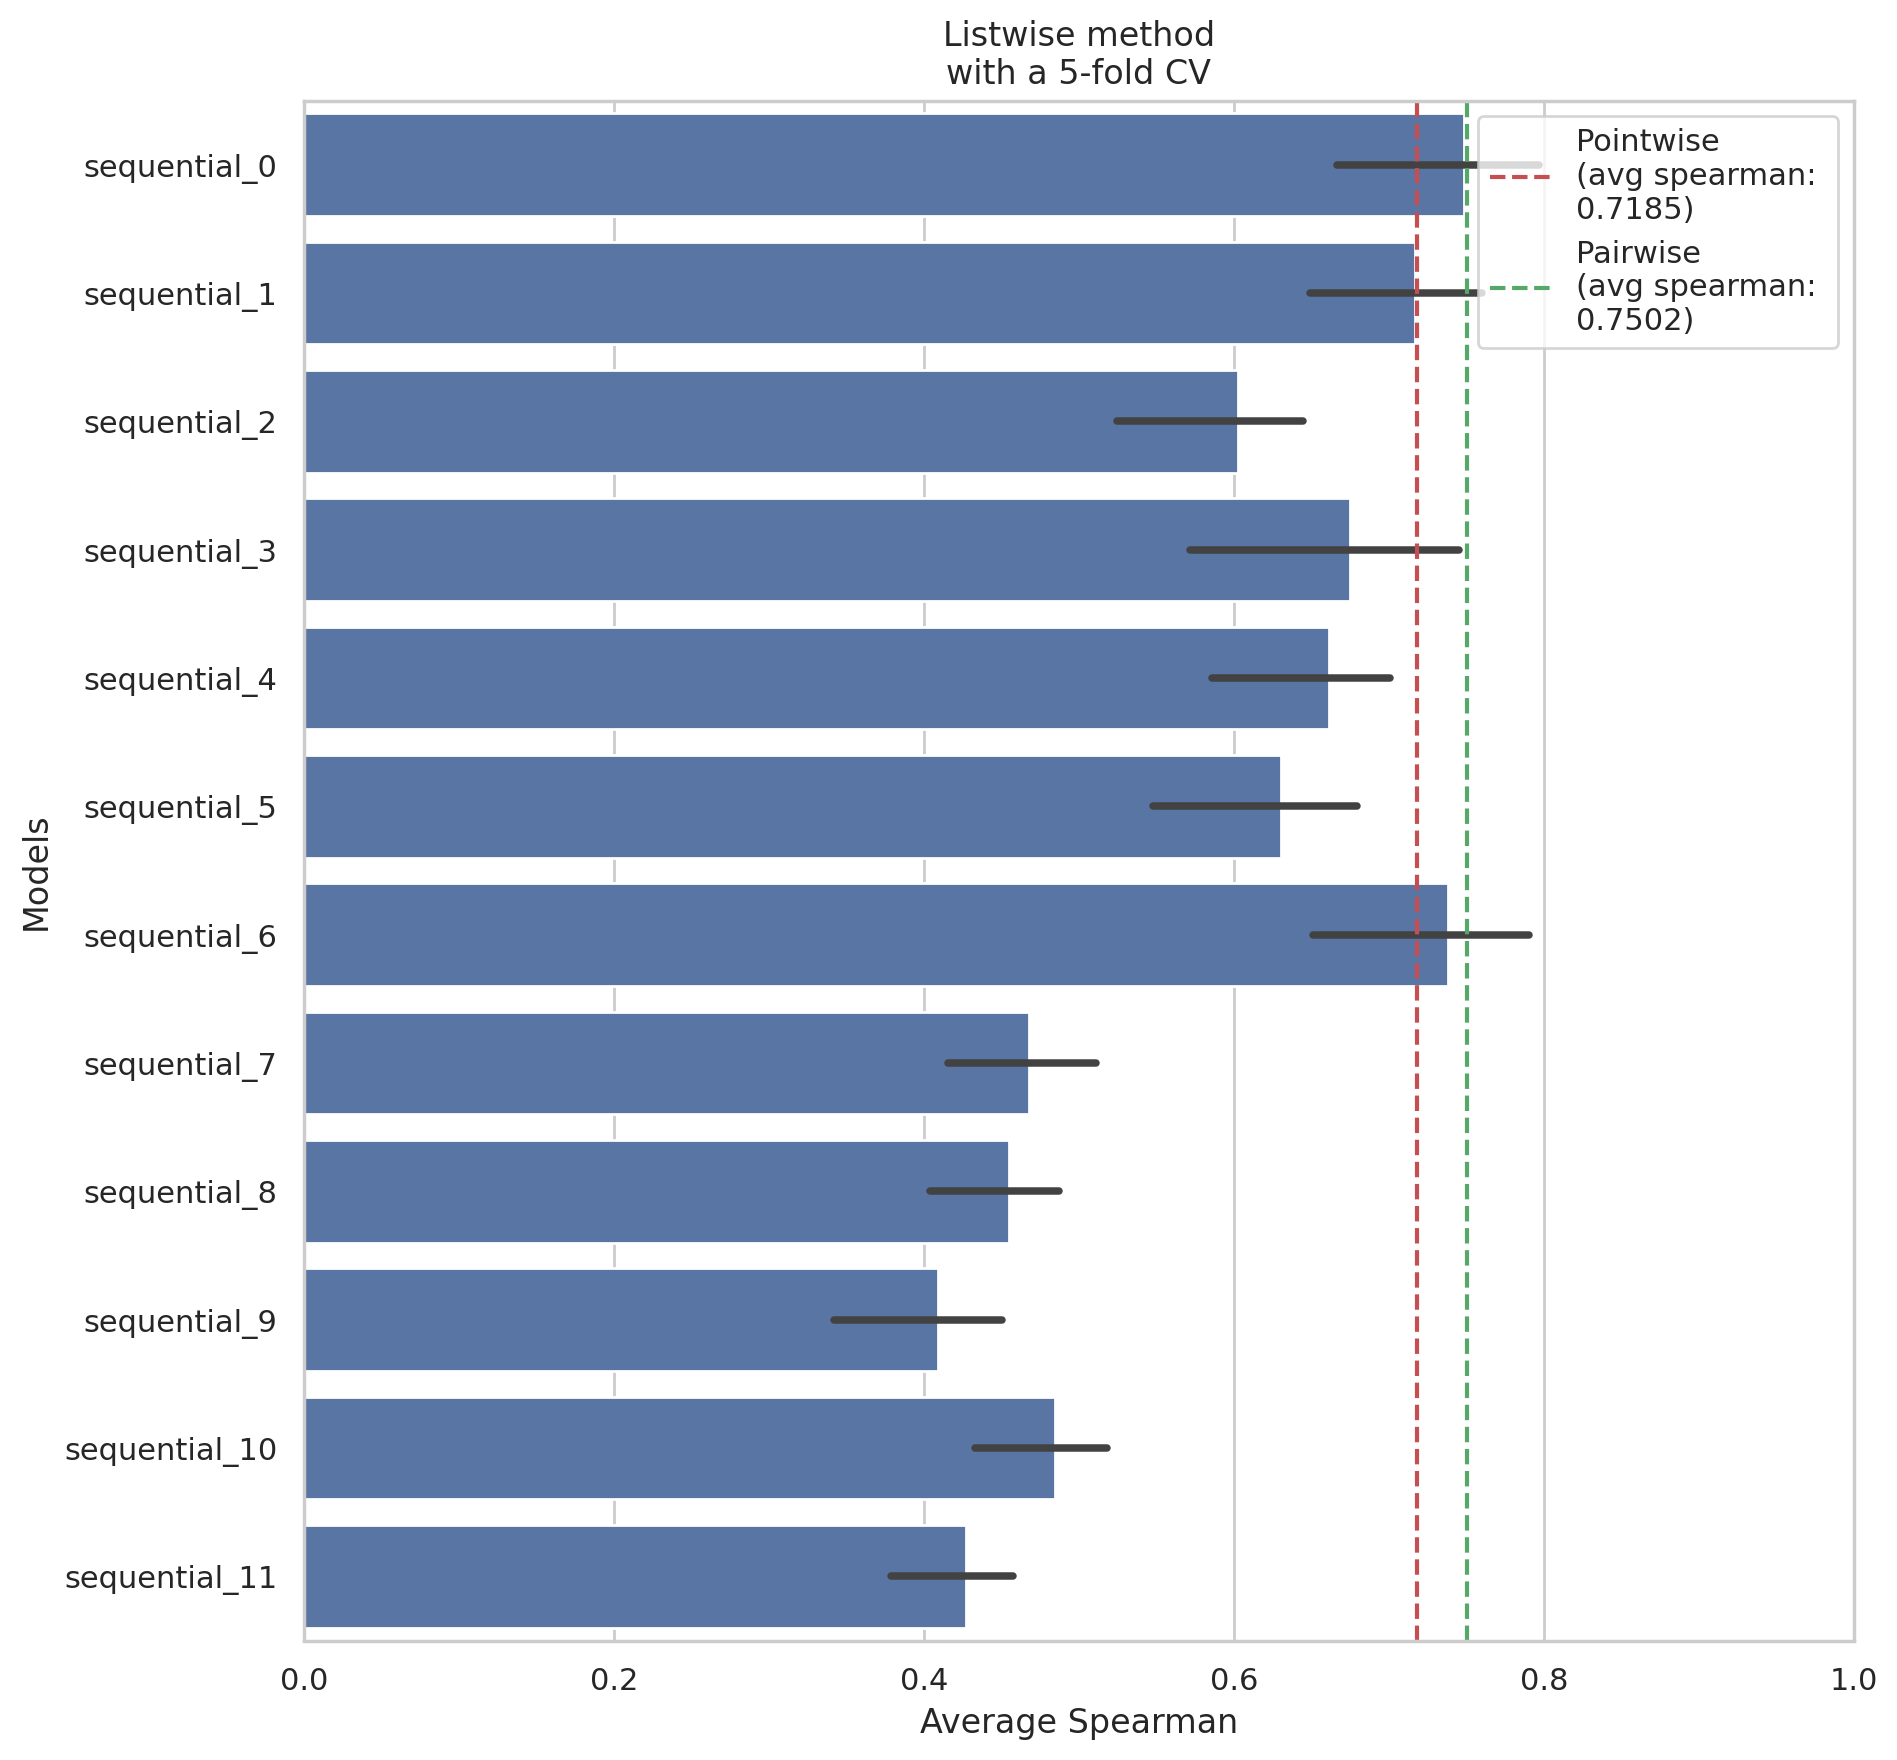

In [24]:
# Models 0 - 11
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, y="model", x="avg_spearman", ax=axes, color="b")
plot.axvline(0.7185, color='r', ls='--', label='Pointwise \n(avg spearman: \n0.7185)')
plot.axvline(0.7502, color='g', ls='--', label='Pairwise \n(avg spearman: \n0.7502)')
plot.set(title="Listwise method\nwith a 5-fold CV")
plot.set_xlim([0.0, 1.0])
plot.legend(loc='upper right')

plot.set_ylabel("Models")
plot.set_xlabel("Average Spearman")

# Rotate items on x axis
#for item in axes.get_xticklabels():
#        item.set_rotation(90)

# Save figures
#f = plot.get_figure()
#f.savefig("Model_evaluation_blue.png") 
#f.savefig("Model_evaluation_blue.svg")

Text(0.5, 0, 'Average Spearman')

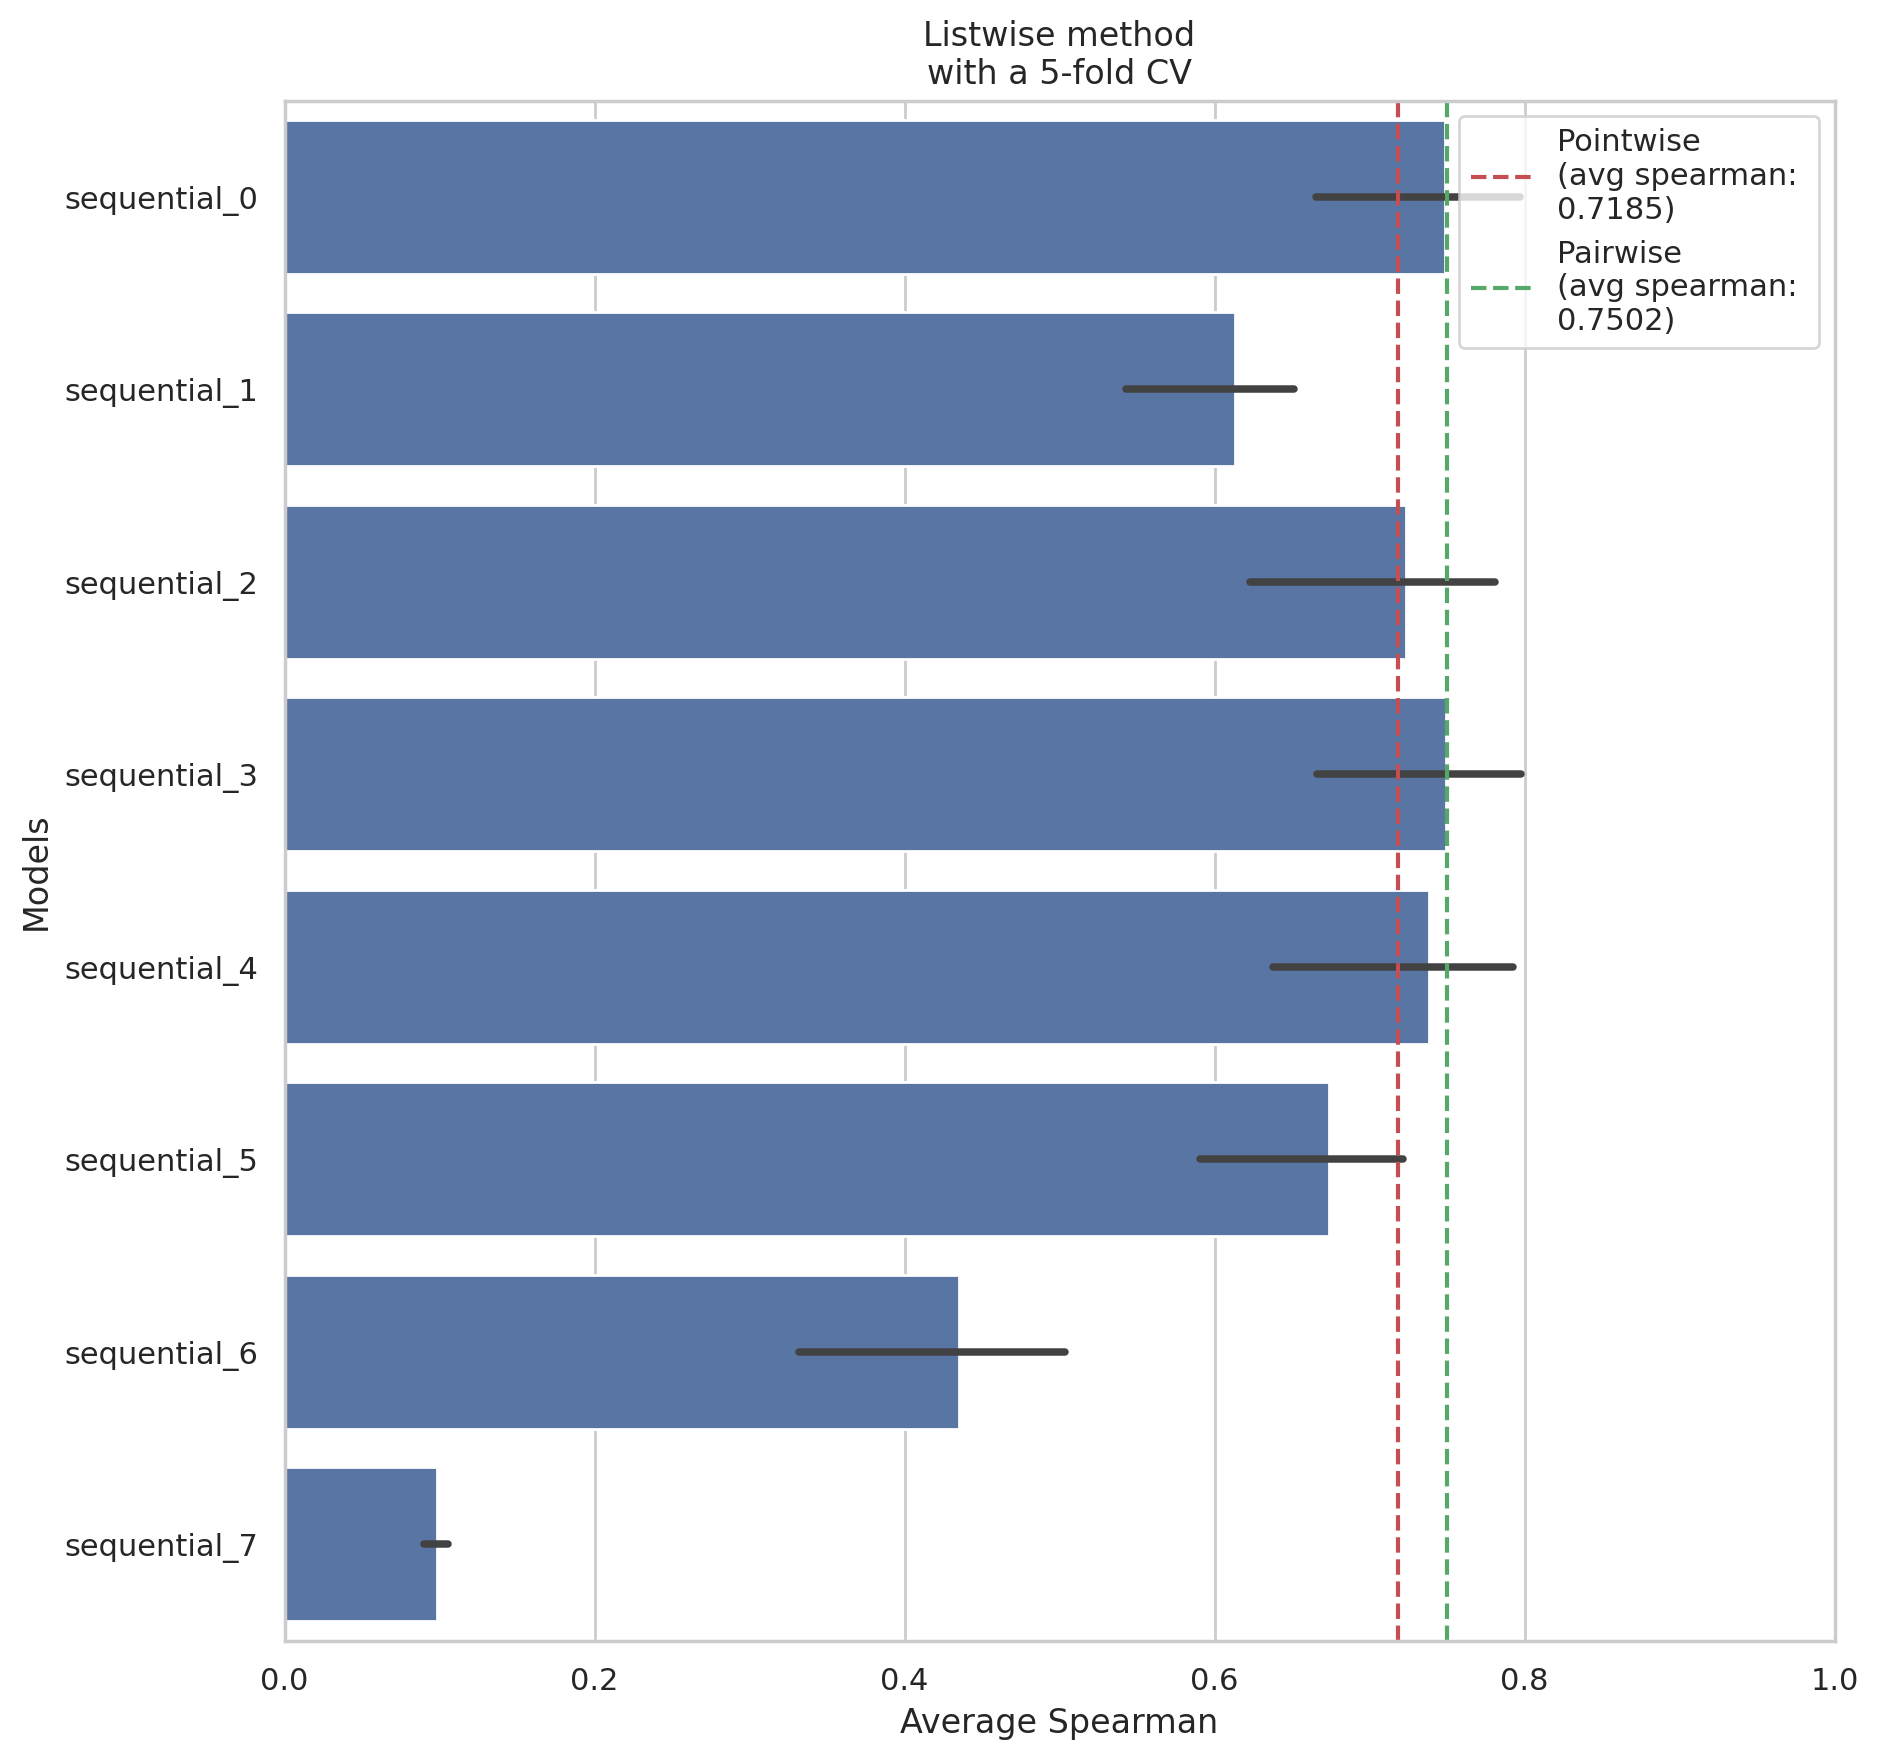

In [23]:
# Models 12 - 19
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, y="model", x="avg_spearman", ax=axes, color="b")
plot.axvline(0.7185, color='r', ls='--', label='Pointwise \n(avg spearman: \n0.7185)')
plot.axvline(0.7502, color='g', ls='--', label='Pairwise \n(avg spearman: \n0.7502)')
plot.set(title="Listwise method\nwith a 5-fold CV")
plot.set_xlim([0.0, 1.0])
plot.legend(loc='upper right')

plot.set_ylabel("Models")
plot.set_xlabel("Average Spearman")

Text(0.5, 0, 'Average Spearman')

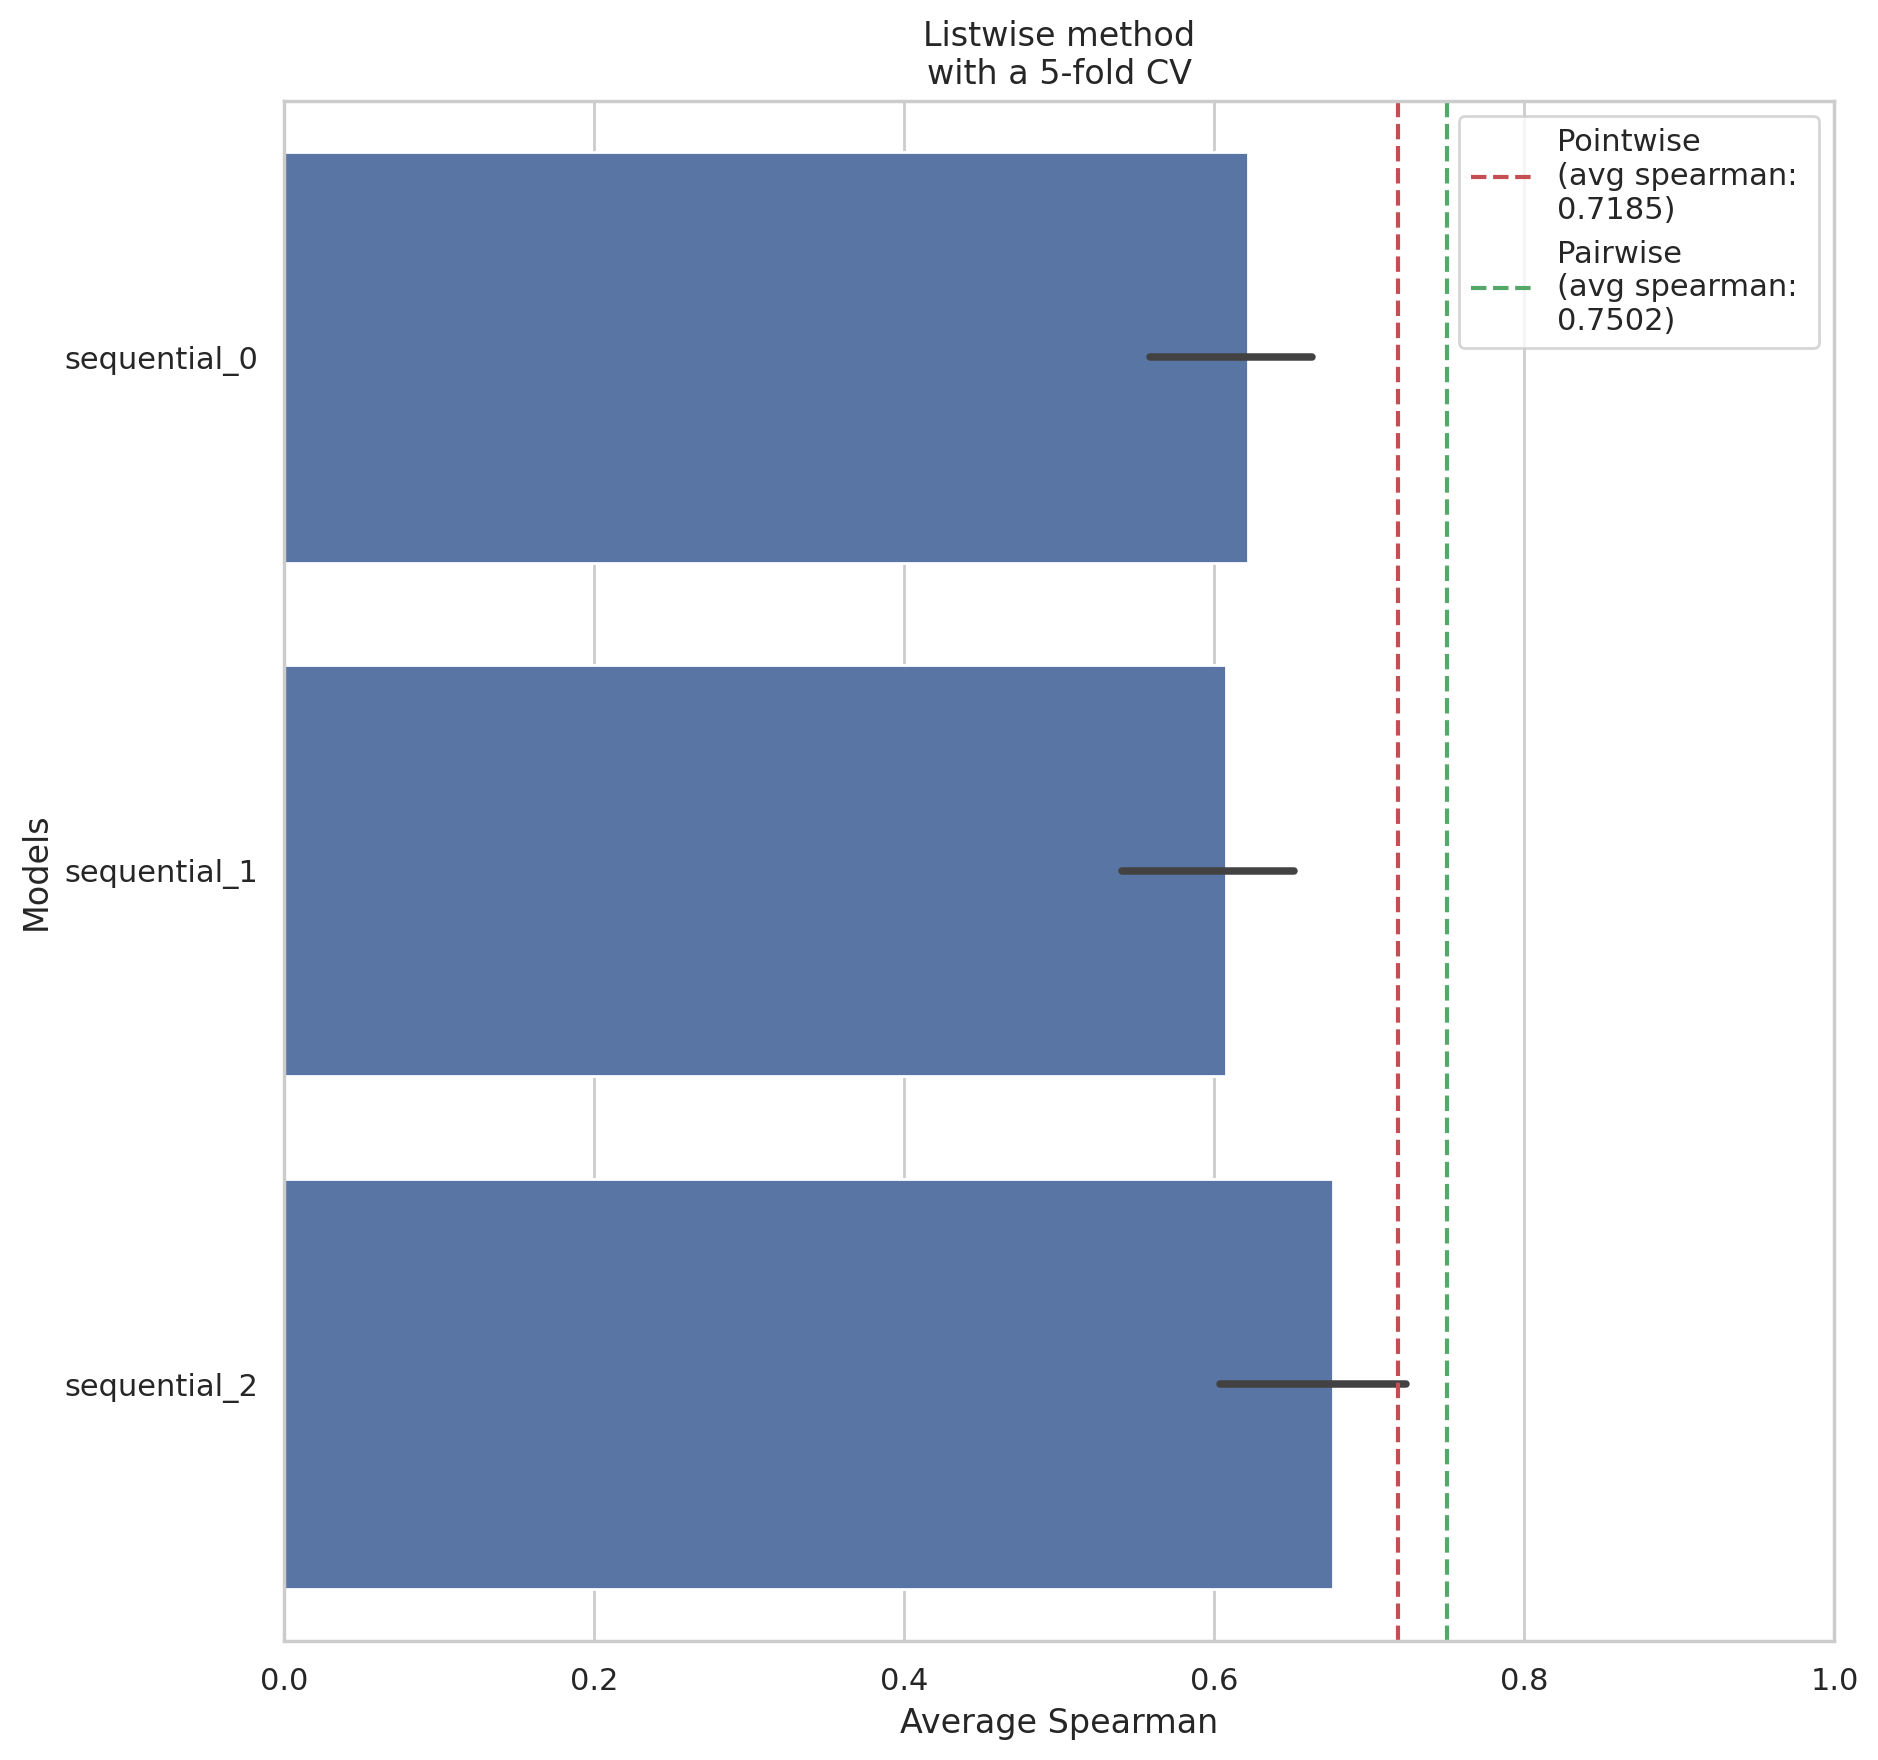

In [32]:
# Models 12 - 19
fig, axes = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, y="model", x="avg_spearman", ax=axes, color="b")
plot.axvline(0.7185, color='r', ls='--', label='Pointwise \n(avg spearman: \n0.7185)')
plot.axvline(0.7502, color='g', ls='--', label='Pairwise \n(avg spearman: \n0.7502)')
plot.set(title="Listwise method\nwith a 5-fold CV")
plot.set_xlim([0.0, 1.0])
plot.legend(loc='upper right')

plot.set_ylabel("Models")
plot.set_xlabel("Average Spearman")

### Fit time

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="fitting_time", color="b")  # ax=axes, 
#plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Fitting time")
#plot.set_ylim([0.0, 1.0])
#plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Fitting time in seconds")

# Save figures
#f = plot.get_figure()
#f.savefig("Fitting_time_mako.png") 
#f.savefig("Fitting_time_mako.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)

### Prediction time

In [ ]:
fig, axes = plt.subplots(figsize=(10, 5), nrows=1, ncols=1)
plot = sns.barplot(data=df_plot, x="model", y="prediction_time", color="b")  # ax=axes, 
#plot.axhline(0.7185, color='r', ls='--', label='Baseline model (avg spearman: 0.7185)')
plot.set(title="Prediction time")
#plot.set_ylim([0.0, 1.0])
#plot.legend()

plot.set_xlabel("Models")
plot.set_ylabel("Prediction time in seconds")

# Save figures
#f = plot.get_figure()
#f.savefig("Prediction_time_mako.png") 
#f.savefig("Prediction_time_mako.svg")

# Rotate items on x axis
for item in axes.get_xticklabels():
        item.set_rotation(90)

### Learning curve

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
for key, item in histories.items():
    loss = item.history["loss"]
    sns.lineplot(x=np.arange(1, epochs+1), y=loss, label=key, ax=axes[0])
axes[0].legend()
axes[0].set_title("Loss in each Epoch and Fold")
axes[0].set_xlabel("# Epoch")
axes[0].set_ylabel("Loss")
# Second plot
sns.barplot(x=np.arange(0, len(scores)), y=scores, ax=axes[1], edgecolor="black")
axes[1].set_title(f"Average Spearman in each fold on holdout-set" +
                  f" ({np.mean(scores):.4f} +/- {np.std(scores):.4f})")
axes[1].set_xlabel("k-fold")
axes[1].set_ylabel("Average Spearman")
axes[1].axhline(y=np.mean(scores), linestyle="--", color="red")
plt.show()